# Demo: sequences <-> networks
The following notebook provides a demonstration how the ts2g2 library can be used to convert time series into graphs and graphs into time series. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN). All the column descriptions are provided. Currency is USD.

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from timeseries.strategies import TimeseriesToGraphStrategy, TimeseriesEdgeVisibilityConstraintsNatural, TimeseriesEdgeVisibilityConstraintsHorizontal, EdgeWeightingStrategyNull
from generation.strategies import RandomWalkWithRestartSequenceGenerationStrategy, RandomWalkSequenceGenerationStrategy, RandomNodeSequenceGenerationStrategy, RandomNodeNeighbourSequenceGenerationStrategy, RandomDegreeNodeSequenceGenerationStrategy
from core import model 
from sklearn.model_selection import train_test_split

## Loading data 

We first load the dataset :)

In [3]:
amazon_data = pd.read_csv(os.path.join(os.getcwd(), "amazon", "AMZN.csv"))

To properly use the ‘Date’ column, we convert it to datetime format and ensure the dates are recognized as date objects. We then set the ‘Date’ column as the index of the DataFrame. This creates a time-series structure, facilitating analysis and visualization over time.

In [4]:
amazon_data["Date"] = pd.to_datetime(amazon_data["Date"])
amazon_data.set_index("Date", inplace=True)

# How does the time series look like?

In [5]:
def plot_timeseries(sequence, title, x_legend, y_legend, color):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence, linestyle='-', color=color)
    
    plt.title(title)
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.grid(True)
    plt.show()

In [6]:
def plot_timeseries_sequence(df_column, title, x_legend, y_legend, color='black'):
    sequence = model.Timeseries(model.TimeseriesArrayStream(df_column)).to_sequence()
    plot_timeseries(sequence, title, x_legend, y_legend, color)

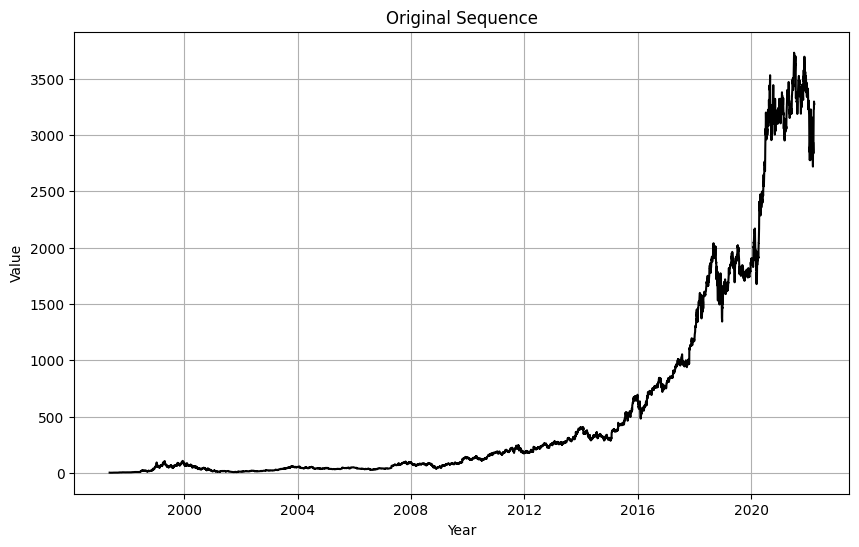

In [7]:
plot_timeseries_sequence(amazon_data["Close"], "Original Sequence", "Year", "Value")

Given the great length of the timeseries, let's focus on some sub-segments, so that we can better appreciate its behavior.

In [8]:
segment_1 = amazon_data[60:120]
segment_2 = amazon_data[4000:4060]
segment_3 = amazon_data[6000:6060]

How do the plots for these segments look like?

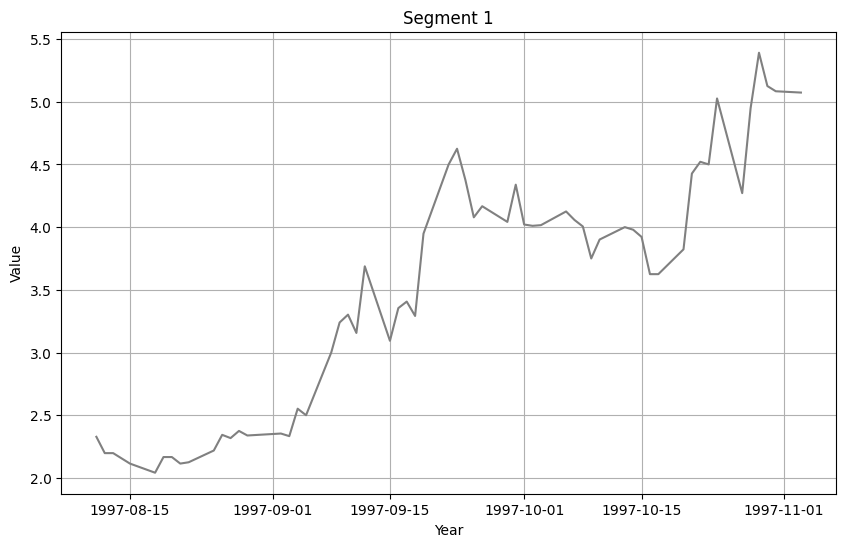

In [9]:
plot_timeseries_sequence(segment_1["Close"], "Segment 1", "Year", "Value", 'gray')

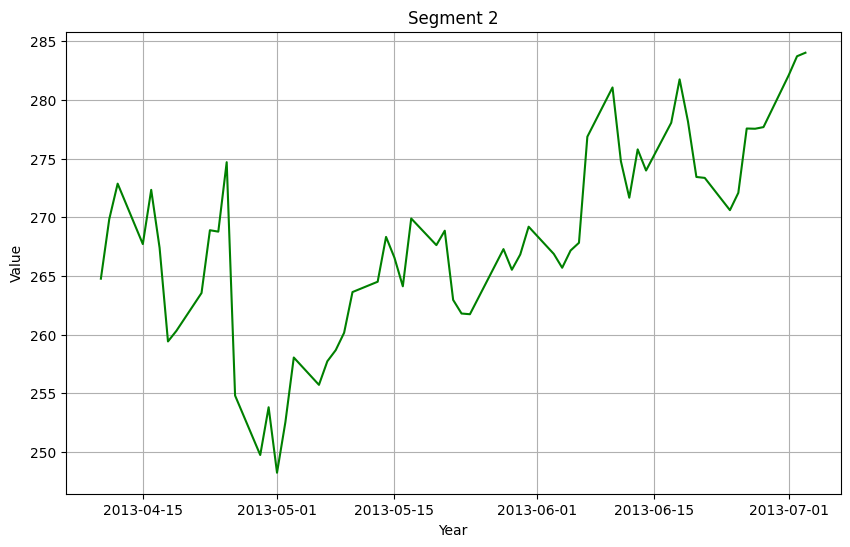

In [10]:
plot_timeseries_sequence(segment_2["Close"], "Segment 2", "Year", "Value", 'green')

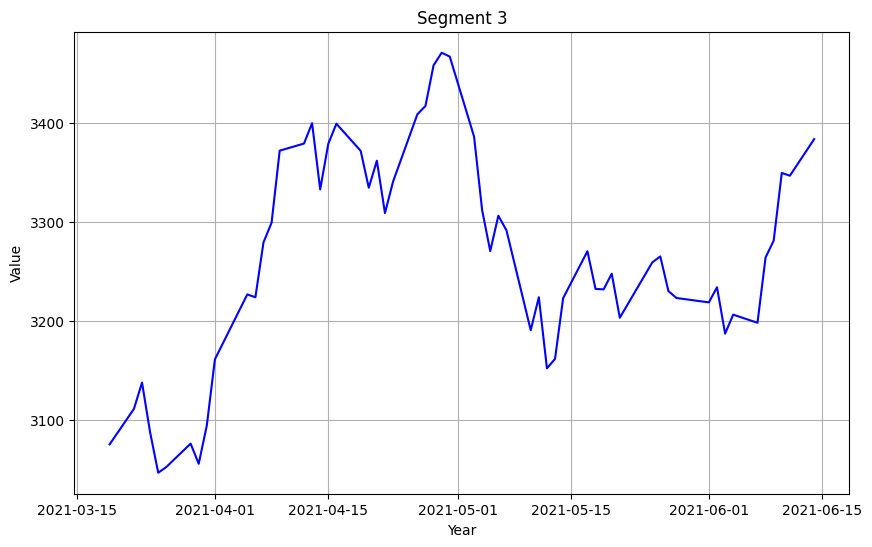

In [11]:
plot_timeseries_sequence(segment_3["Close"], "Segment 3", "Year", "Value", 'blue')

Let's turn the timeseries into networks (graphs)!

In [12]:
def sequence_to_graph(column, color):
    strategy = TimeseriesToGraphStrategy(
        visibility_constraints=[TimeseriesEdgeVisibilityConstraintsNatural()],
        graph_type="undirected",
        edge_weighting_strategy=EdgeWeightingStrategyNull(),
    )

    g = strategy.to_graph(model.TimeseriesArrayStream(column))
    pos=nx.spring_layout(g.graph, seed=1)
    nx.draw(g.graph, pos, node_size=40, node_color=color)

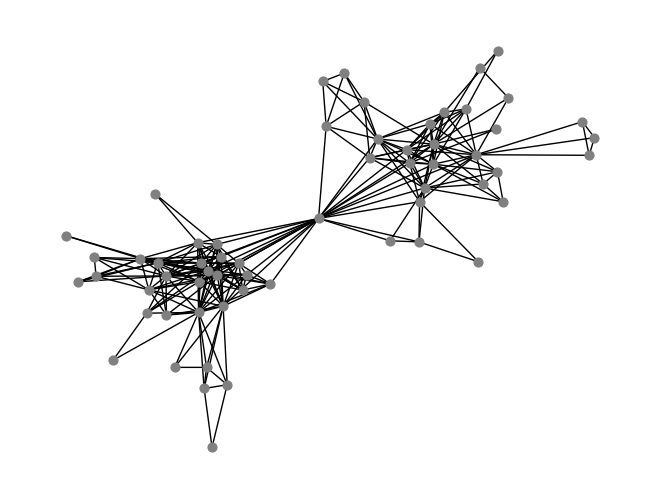

In [13]:
sequence_to_graph(segment_1["Close"], 'gray')

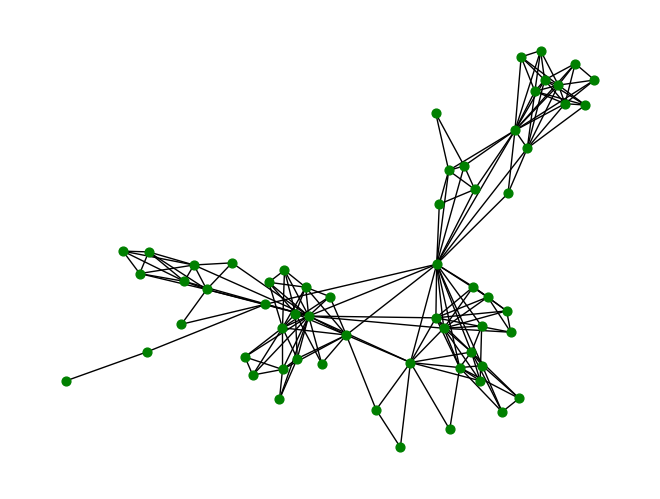

In [14]:
sequence_to_graph(segment_2["Close"], 'green')

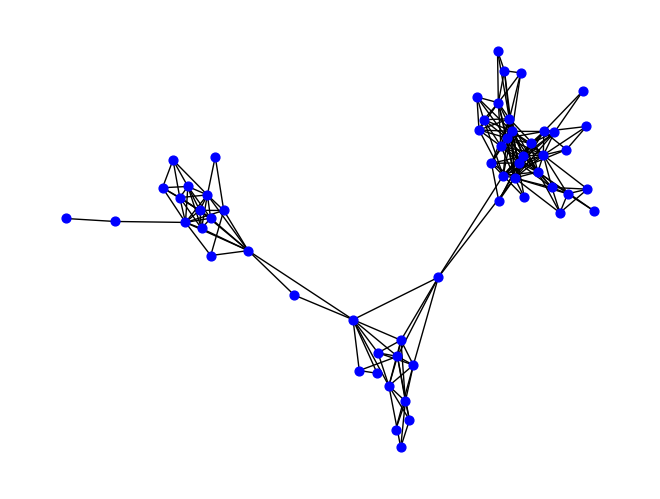

In [15]:
sequence_to_graph(segment_3["Close"], 'blue')

They look quite different! Many different strategies for converting timeseries into graphs exist:
 - TimeseriesEdgeVisibilityConstraintsNatural
 - TimeseriesEdgeVisibilityConstraintsHorizontal
 - TimeseriesEdgeVisibilityConstraintsVisibilityAngle

Now let's try to create a sequence generator, based on a graph. We will first divide each sequence into train/test sets.

In [16]:
def generate_sequence(df, reference_column, color):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=100)
    stream_train = model.TimeseriesArrayStream(df_train[reference_column])

    strategy = TimeseriesToGraphStrategy(
        visibility_constraints=[TimeseriesEdgeVisibilityConstraintsNatural()],
        graph_type="undirected",
        edge_weighting_strategy=EdgeWeightingStrategyNull(),
    )
    graph = strategy.to_graph(stream_train)
    test_length = len(df_test.index)
    sequence = graph.to_sequence(RandomWalkWithRestartSequenceGenerationStrategy(), sequence_length=test_length)
    
    dfx = pd.DataFrame(
    {'y_true': df[reference_column].values,
     'y_pred': [None]*len(df_train.index)+sequence
    })
    dfx.index = df.index
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dfx['y_true'], linestyle='-.', color=color)
    plt.plot(dfx['y_pred'], linestyle='-', color='black')
    plt.title("Random Walk With Restart Sequence Generated Strategy")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(False)
    plt.show()

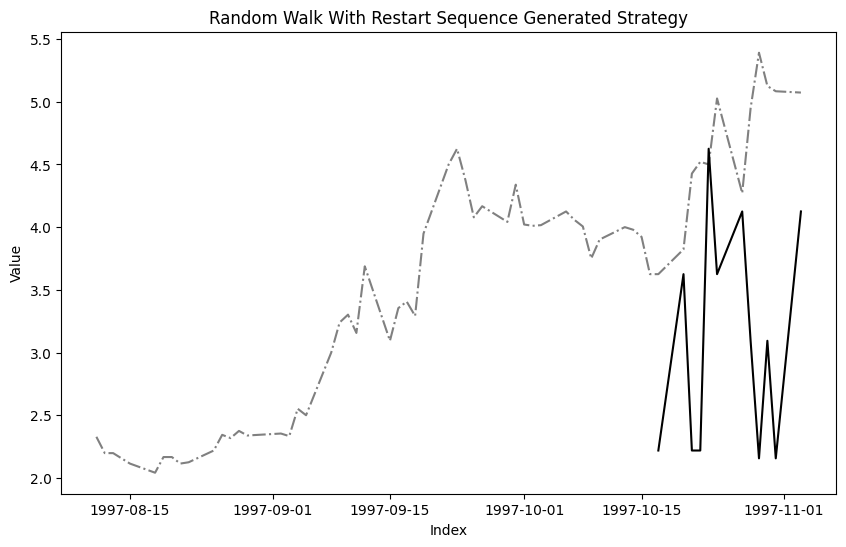

In [17]:
generate_sequence(segment_1, 'Close', 'gray')

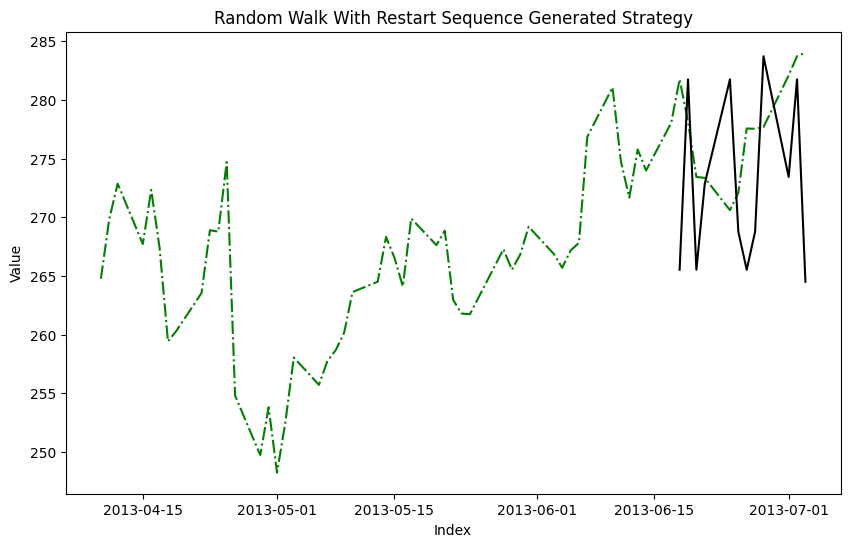

In [18]:
generate_sequence(segment_2, 'Close', 'green')

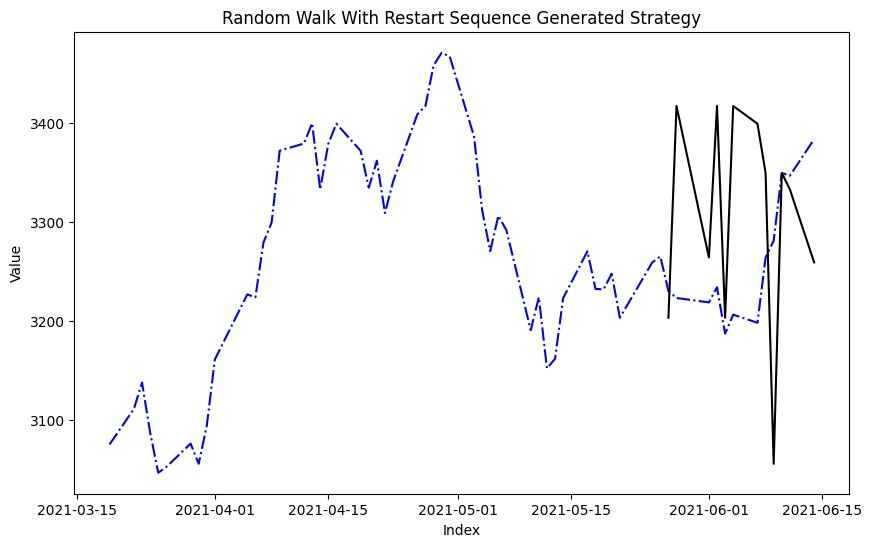

In [19]:
generate_sequence(segment_3, 'Close', 'blue')

Many additional strategies for converting graphs to timeseries exist: 
 - RandomWalkWithRestartSequenceGenerationStrategy
 - RandomWalkSequenceGenerationStrategy
 - RandomNodeSequenceGenerationStrategy
 - RandomDegreeNodeSequenceGenerationStrategy
 - RandomDegreeNodeSequenceGenerationStrategy
 - RandomNodeNeighbourSequenceGenerationStrategy